In [1]:
import numpy as np
import math
import time
import scipy.signal
from astropy.convolution import convolve, Kernel
from nexusformat.nexus import *
import matplotlib.pyplot as plt
import matplotlib.colors as colors

figdir = '/users/charlottehaley/Documents/Repos/xray/Doc/Figures/CDW_window/'

# 1D Window

From the undergraduate table of Fourier transforms, we have the following Gaussian transform pair
$$f(t) = e^{-t^2/(2\sigma^2)} $$
$$\hat{f}(\omega) = \sigma \sqrt{2\pi} e^{-\sigma^2\omega^2/2} $$
That is, 
$$ \hat{f}(\omega) = \int_{-\infty}^{\infty} f(t) e^{-i\omega t} dt. $$

We also have the discrete characteristic function on a symmetric interval
$$ \chi_{[\alpha,\alpha]}(t) = \left \{ \begin{array}{cc} 1/\sqrt{2\alpha + 1} & \mbox{for } t = -\alpha,\ldots,\alpha \\ 
                                    0 & \mbox{ for } t = -N/2 , \ldots, -\alpha - 1, \alpha+1, \ldots, N/2 -1\end{array} \right. $$
for some integer $\alpha > 0$ and $N$ even. Note that this function has been scaled to have unit norm.
Denoting the Fourier transform with a hat and using angular
frequencies, one obtains
$$
\hat{\chi}_{[\alpha,\alpha]}(\omega) = \frac{e^{i \alpha \omega} - e^{- i \alpha
\omega}}{\sqrt{2\alpha} i \omega} \\
 = \sqrt{\frac{1}{2\alpha+1}} \cdot \frac{ 2 \sin \alpha \omega}{ \omega} \label{eq:sinc}
$$

<ipython-input-2-63bf9c3a2fed>:11: RuntimeWarning: invalid value encountered in true_divide
  S = 2*np.sin(2*stdev*np.pi*f)/(np.pi*2*f)


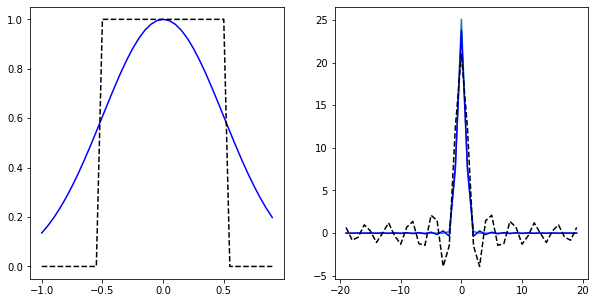

In [2]:
# Start in 1D 
hN = 20
N = 2*hN 
x = np.arange(-hN,hN-1)
f = np.delete(np.linspace(-0.5,0.5,N+1),0)
stdev = 10

# Step function
s = np.zeros(len(x))
s[hN-stdev:hN+stdev+1] = 1.0
S = 2*np.sin(2*stdev*np.pi*f)/(np.pi*2*f)

#Gaussian window
z = np.exp(-(1/(2*stdev**2))*np.abs(x**2))[range(2*hN-1)]
Z = stdev*np.sqrt(2*np.pi)*np.exp(-stdev**2*(2*np.pi*f)**2/2)[range(2*hN-1)]

# We remove the last element of z for a proper signal when made periodic
Z_fft = np.fft.fftshift(np.real(np.fft.fft(np.fft.fftshift(z))))
Z_fft = np.fft.fftshift(np.real(np.fft.fft(np.fft.fftshift(z))))
S_fft = np.fft.fftshift(np.real(np.fft.fft(np.fft.fftshift(s))))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(x/hN,z,"b-")
ax1.plot(x/hN,s,"k--")
ax2.plot(x+1, Z)
ax2.plot(x+1, Z_fft,"b-")
ax2.plot(x+1, S_fft,"k--")
#ax2.plot(S)

plt.savefig(figdir + "sinc.png")

Suppose we have peaks at 1/2 integer locations.

<ipython-input-3-7ca913ac3bd6>:13: RuntimeWarning: invalid value encountered in true_divide
  S = 2*np.sin(2*stdev*np.pi*f)/(np.pi*2*f)


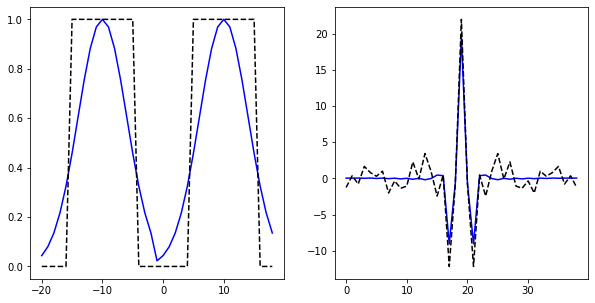

In [3]:
# Start in 1D 
N = 2*hN 
hN2 = 10
x = np.arange(-hN,hN-1)
f = np.delete(np.linspace(-0.5,0.5,N+1),0)
stdev = 4
stdev2 = 5

# Step function
s = np.zeros(len(x))
s[hN-stdev2-hN2:hN+stdev2+1-hN2] = 1.0
s[hN-stdev2+hN2:hN+stdev2+1+hN2] = 1.0
S = 2*np.sin(2*stdev*np.pi*f)/(np.pi*2*f)

#Gaussian window
z = np.exp(-(1/(2*stdev**2))*np.abs(np.arange(-11,10)**2))[range(hN)]
z = np.delete(np.tile(z,(2,)),0)
Z = stdev*np.sqrt(2*np.pi)*np.exp(-stdev**2*(2*np.pi*f)**2/2)

# We remove the last element of z for a proper signal when made periodic
Z_fft = np.fft.fftshift(np.real(np.fft.fft(np.fft.fftshift(z))))
S_fft = np.fft.fftshift(np.real(np.fft.fft(np.fft.fftshift(s))))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(x,z,"b-")
ax1.plot(x,s,"k--")
# ax2.plot(Z)
ax2.plot(Z_fft,"b-")
ax2.plot(S_fft,"k--")
# ax2.plot(S)

plt.savefig(figdir + "cdwpk.png")

Repeating the same template three times results in zero insertion (and scaling) in the DFT. That is, tiling the Gaussian three times results in insertion of two zeros between every point in the DFT. (See https://www.dsprelated.com/freebooks/mdft/Fourier_Theorems_DFT.html under "repeat operator" to see this.) Note that in order to properly tile the 1D signal you have to remove the last observation. 

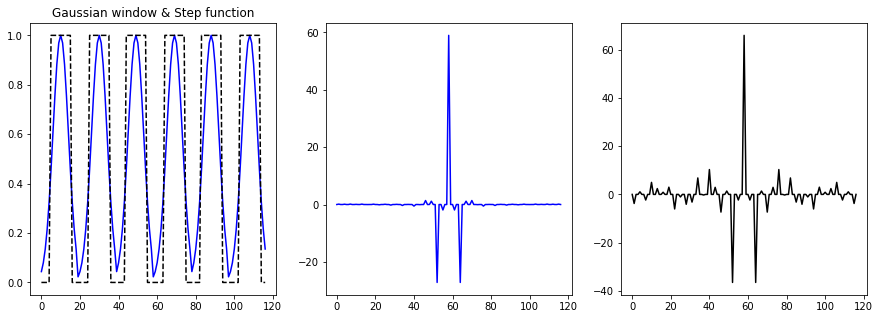

In [4]:

# Here's the signal repeated three times and its fft
z3 = np.tile(z,(3,))
#Z3_fft = np.fft.fftshift(np.real(np.fft.fft(np.fft.fftshift(z3))))
Z3_fft = np.fft.fftshift(np.real(np.fft.fft(np.fft.fftshift(z3))))

# Here's the step function repeated three times and its fft
s3 = np.tile(s,(3,))
S3_fft = np.fft.fftshift(np.real(np.fft.fft(np.fft.fftshift(s3))))

# In order to get the DFT of the tiled signal from the DFT of the original signal, we insert zeros and scale
Z3_zeroins = 3*np.reshape(np.vstack((np.zeros((1,len(Z))),Z,np.zeros((1,len(Z))))),(3*len(Z),), order='F')

# Here is the solution to the non-repeated guy with three times the length
Z3 = 3*stdev*np.sqrt(2*np.pi)*np.exp(-stdev**2*(2*np.pi*np.arange(-3*hN+1,3*hN)/3)**2/2) 

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
ax1.plot(z3,"b-")
ax1.plot(s3,"k--")
ax1.set_title("Gaussian window & Step function")
ax2.plot(Z3_fft,"b-")
# ax2.plot(Z3_zeroins,"b-")
ax3.plot(S3_fft,"k-")

#ax2.plot(Z3)

plt.savefig(figdir + "sincgauss_tiled.png")

It is clear that one gets more distortion by masking with a step function than by masking with a Gaussian. The artifact to beware of is the zero insertion introduced by repeating the mask.

# 2D Example

We can do the same experiment in 2D

In [5]:
# Start in 2D 
xg = np.linspace(-1.0,1,21)[range(20)]
yg = np.linspace(-1.0,1,21)[range(20)]
Xg,Yg = np.meshgrid(xg,yg)
stdev = 1.0/10

#Gaussian window
z2d = np.exp(-(1/(2*stdev))*np.abs(Xg**2 + Yg**2))

# Suppose we just use the 0-1 mask that cuts out little circles around each CDW peak
circ = np.sqrt(Xg**2 + Yg**2) < 0.21

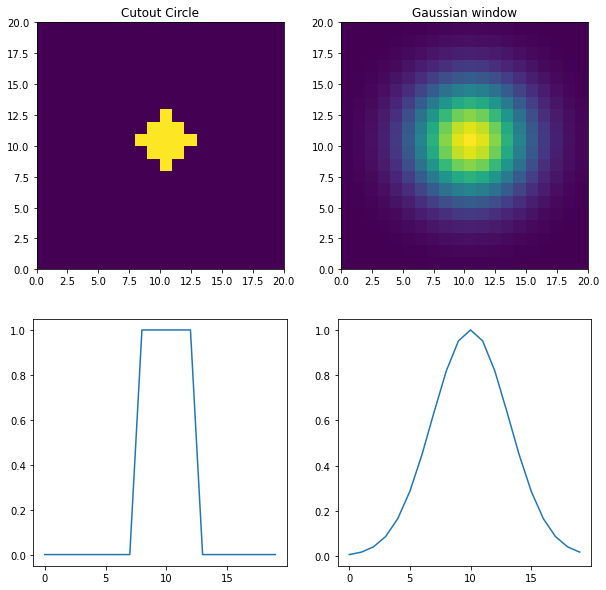

In [6]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))

# little circles
ax1.pcolor(circ)
ax1.set_title('Cutout Circle')
ax1.set_aspect('equal', 'box')
# Gaussian window
ax2.pcolor(z2d)
ax2.set_title('Gaussian window')
ax2.set_aspect('equal', 'box')

ax3.plot(circ[:,10])
ax4.plot(z2d[:,10])

# plt.savefig(figdir + 'Circ_Gauss.png')

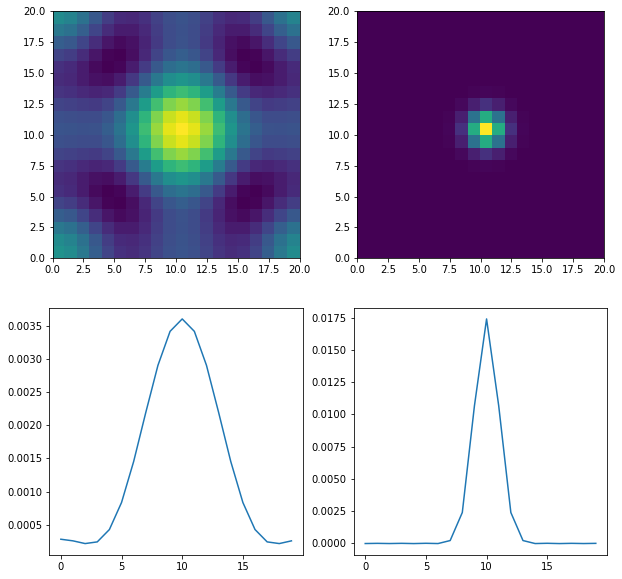

In [7]:
Z2D = (1/60**2)*np.fft.fftshift(np.real(np.fft.fftn(np.fft.fftshift(z2d))))
CIRC = (1/60**2)*np.fft.fftshift(np.real(np.fft.fftn(np.fft.fftshift(circ))))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))

# little circles
ax1.pcolor(CIRC)
ax1.set_aspect('equal', 'box')
# Gaussian window
ax2.pcolor(Z2D)
ax2.set_aspect('equal', 'box')

ax4.plot(Z2D[:,10])
ax3.plot(CIRC[:,10])

## 2D tiling
The locations of the CDW peaks are at (1/2,1/2) & symmetric points
```
a = np.zeros((10,10))
a[5,5] = 1.0
cdw_locs = np.tile(a,(10,10))

x = np.linspace(-5.0,4.99,100)
y = np.linspace(-5.0,4.99,100)
X,Y = np.meshgrid(x,y)

plt.pcolor(X,Y,cdw_locs)
```

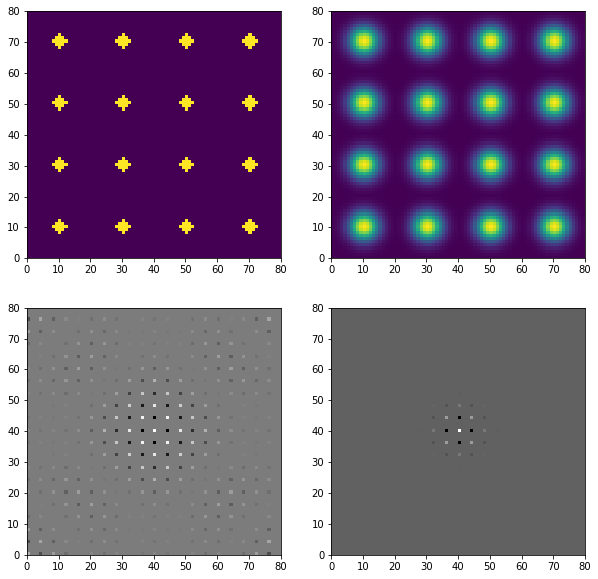

In [8]:
z2d_3tiled = np.tile(z2d,(4,4))
circ_3tiled = np.tile(circ,(4,4))

# Compute the FFTs
G = np.fft.fftshift(np.real(np.fft.fftn(np.fft.fftshift(z2d_3tiled))))
C = np.fft.fftshift(np.real(np.fft.fftn(np.fft.fftshift(circ_3tiled))))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax2.pcolor(z2d_3tiled)
ax1.pcolor(circ_3tiled)
ax4.pcolor(G,cmap="gray")
ax3.pcolor(C,cmap="gray")

plt.savefig(figdir + '2Dcirc_Gauss.png')

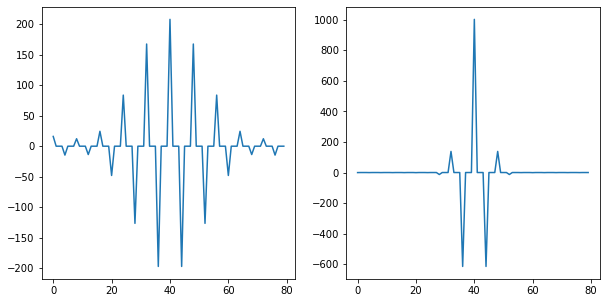

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(C[40,:])
ax2.plot(G[40,:])

plt.savefig(figdir + '2Dcirc_Gauss_slice.png')

<ipython-input-10-906415552c0d>:2: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  p2 = ax.pcolor(G[40:80,40:80],norm=colors.SymLogNorm(linthresh=0.001, linscale=1.0,


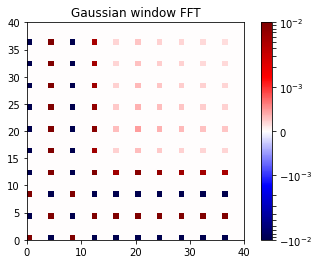

In [10]:
fig,ax = plt.subplots()
p2 = ax.pcolor(G[40:80,40:80],norm=colors.SymLogNorm(linthresh=0.001, linscale=1.0,
                                              vmin=-0.01, vmax=0.01),
                       cmap='seismic')
ax.set_title('Gaussian window FFT')
ax.set_aspect('equal', 'box')
fig.colorbar(p2,ax=ax)

plt.savefig(figdir + 'CG_diff.png')

# In 3D

Here we have more pronounced distortion from spherical masking, on top of the zero insertion.

<ipython-input-11-e759c30aa116>:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolor(Xx1g,Xx2g,sph[:,:,10],cmap="gray_r")
<ipython-input-11-e759c30aa116>:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax2.pcolor(Xx1g,Xx2g,z3d[:,:,10],cmap="gray_r")


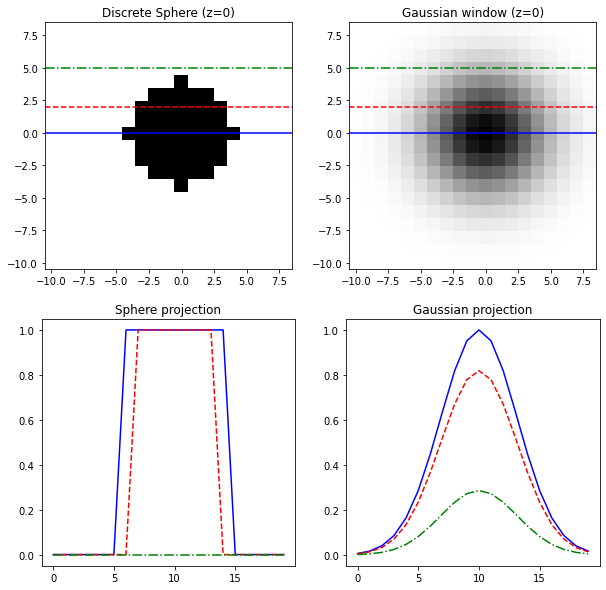

In [11]:
# Start in 2D 
x1g = np.linspace(-1.0,1,21)[range(20)]
x2g = np.linspace(-1.0,1,21)[range(20)]
x3g = np.linspace(-1.0,1,21)[range(20)]
X1g,X2g,X3g = np.meshgrid(x1g,x2g,x3g)
stdev = 1.0/10

#Gaussian window
z3d = np.exp(-(1/(2*stdev))*np.abs(X1g**2 + X2g**2 + X3g**2))

# Suppose we just use the 0-1 mask that cuts out little circles around each CDW peak
sph = np.sqrt(X1g**2 + X2g**2 + X3g**2) < 0.41

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))

# Pcolor projection plot
xx1g = np.linspace(-10,9,20)-0.5
xx2g = np.linspace(-10,9,20)-0.5
Xx1g,Xx2g = np.meshgrid(xx1g,xx2g)

# little circles
ax1.pcolor(Xx1g,Xx2g,sph[:,:,10],cmap="gray_r")
ax1.plot(np.array((-10.5,8.5)),np.zeros(2,),'b-')
ax1.plot(np.array((-10.5,8.5)),2*np.ones(2,),'r--')
ax1.plot(np.array((-10.5,8.5)),5*np.ones(2,),'g-.')
ax1.set_title('Discrete Sphere (z=0)')
ax1.set_aspect('equal', 'box')
# Gaussian window
ax2.pcolor(Xx1g,Xx2g,z3d[:,:,10],cmap="gray_r")
ax2.set_title('Gaussian window (z=0)')
ax2.set_aspect('equal', 'box')
ax2.plot(np.array((-10.5,8.5)),np.zeros(2,),'b-')
ax2.plot(np.array((-10.5,8.5)),2*np.ones(2,),'r--')
ax2.plot(np.array((-10.5,8.5)),5*np.ones(2,),'g-.')

# Projection, blue is (y,z=10), black is (y = 2,z = 10)
ax3.plot(sph[:,10,10],'b-')
ax3.plot(sph[:,12,10],'r--')
ax3.plot(sph[:,15,10],'g-.')
ax3.set_title('Sphere projection')
ax4.plot(z3d[:,10,10],'b-')
ax4.plot(z3d[:,12,10],'r--')
ax4.plot(z3d[:,15,10],'g-.')
ax4.set_title('Gaussian projection')

plt.savefig(figdir + "3Dsincgauss.png")

<ipython-input-12-727b77ded874>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolor(W1g,W2g,SPH[:,:,10],cmap="gray_r")
<ipython-input-12-727b77ded874>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax2.pcolor(W1g,W2g,Z3D[:,:,10],cmap="gray_r")


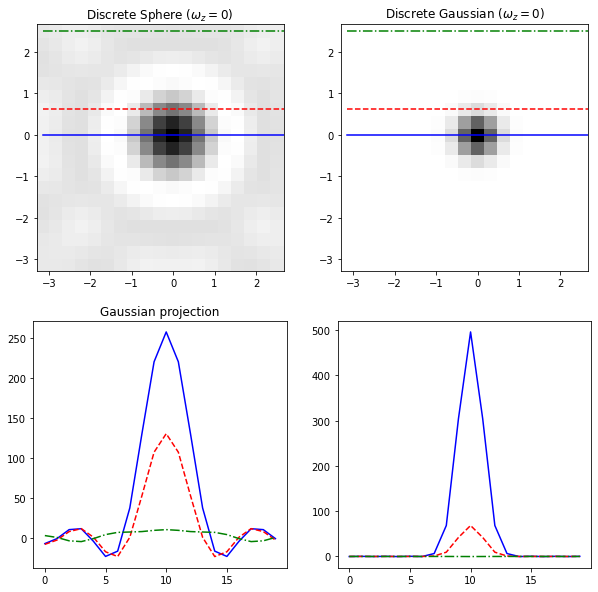

In [12]:
Z3D = np.fft.fftshift(np.real(np.fft.fftn(np.fft.fftshift(z3d))))
SPH = np.fft.fftshift(np.real(np.fft.fftn(np.fft.fftshift(sph))))

# Pcolor projection plot
w1g = np.linspace(-np.pi,np.pi,21)[range(20)] - 0.5*np.pi/10
w2g = np.linspace(-np.pi,np.pi,21)[range(20)] - 0.5*np.pi/10
W1g,W2g = np.meshgrid(w1g,w2g)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))

# little circles
ax1.pcolor(W1g,W2g,SPH[:,:,10],cmap="gray_r")
ax1.plot(np.array((-np.pi,w1g[19])),np.zeros(2,),'b-')
ax1.plot(np.array((-np.pi,w1g[19])),(2*np.pi/10)*np.ones(2,),'r--')
ax1.plot(np.array((-np.pi,w1g[19])),0.8*np.pi*np.ones(2,),'g-.')
ax1.set_title('Discrete Sphere ($\omega_z=0$)')
ax1.set_aspect('equal', 'box')
# Gaussian window
ax2.pcolor(W1g,W2g,Z3D[:,:,10],cmap="gray_r")
ax2.set_aspect('equal', 'box')
ax2.plot(np.array((-np.pi,w1g[19])),np.zeros(2,),'b-')
ax2.plot(np.array((-np.pi,w1g[19])),(2*np.pi/10)*np.ones(2,),'r--')
ax2.plot(np.array((-np.pi,w1g[19])),0.8*np.pi*np.ones(2,),'g-.')
ax2.set_title('Discrete Gaussian ($\omega_z=0$)')


ax3.plot(SPH[:,10,10],'b-')
ax3.plot(SPH[:,12,10],'r--')
ax3.plot(SPH[:,18,10],'g-.')
ax3.set_title('Sphere projection')
ax4.plot(Z3D[:,10,10],'b-')
ax4.plot(Z3D[:,12,10],'r--')
ax4.plot(Z3D[:,18,10],'g-.')
ax3.set_title('Gaussian projection')

plt.savefig(figdir + "3DFTsincgauss.png")

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)

vmin = -4 
vmax = 7
norm47 = colors.DivergingNorm(vmin=vmin, vcenter=0, vmax=vmax)

<ipython-input-13-7fcea92146b5>:12: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm47 = colors.DivergingNorm(vmin=vmin, vcenter=0, vmax=vmax)


<ipython-input-14-073f67f3fe65>:11: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  poc = ax3.pcolor(S[:,:,30],cmap="bwr",vmin=vmin,vmax=vmax,norm=norm47)
<ipython-input-14-073f67f3fe65>:12: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  pog = ax4.pcolor(G3[:,:,30],cmap="bwr",vmin=vmin,vmax=vmax,norm=norm47)


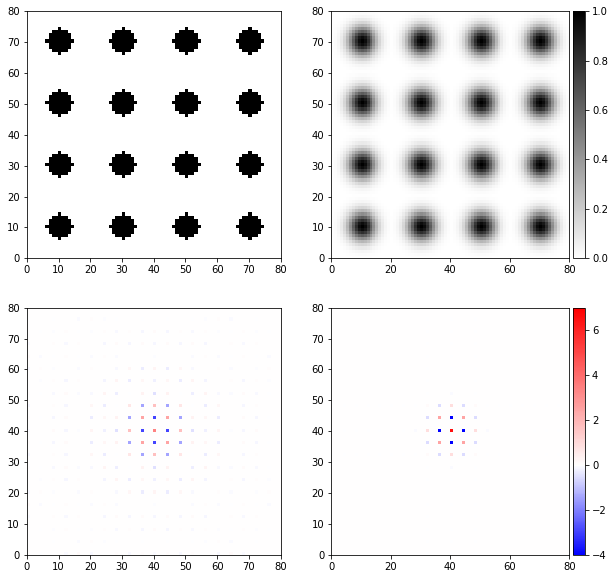

In [14]:
z3d_3tiled = np.tile(z3d,(4,4,3))
sph_3tiled = np.tile(sph,(4,4,3))

# Compute the FFTs
G3 = (1/60**2)*np.fft.fftshift(np.real(np.fft.fftn(np.fft.fftshift(z3d_3tiled))))
S = (1/60**2)*np.fft.fftshift(np.real(np.fft.fftn(np.fft.fftshift(sph_3tiled))))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
upc = ax1.pcolor(sph_3tiled[:,:,30],cmap="gray_r",vmin=0,vmax=1)
upg = ax2.pcolor(z3d_3tiled[:,:,30],cmap="gray_r",vmin=0,vmax=1)
poc = ax3.pcolor(S[:,:,30],cmap="bwr",vmin=vmin,vmax=vmax,norm=norm47)
pog = ax4.pcolor(G3[:,:,30],cmap="bwr",vmin=vmin,vmax=vmax,norm=norm47)

colorbar(upg); colorbar(pog)
plt.savefig(figdir+"3Dtilegauss_zeroZplane.png")

<ipython-input-15-5ef38ee71ac6>:4: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  poc = ax3.pcolor(S[:,:,20],cmap="bwr",vmin=vmin,vmax=vmax,norm=norm47)
<ipython-input-15-5ef38ee71ac6>:5: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  pog = ax4.pcolor(G3[:,:,20],cmap="bwr",vmin=vmin,vmax=vmax,norm=norm47)


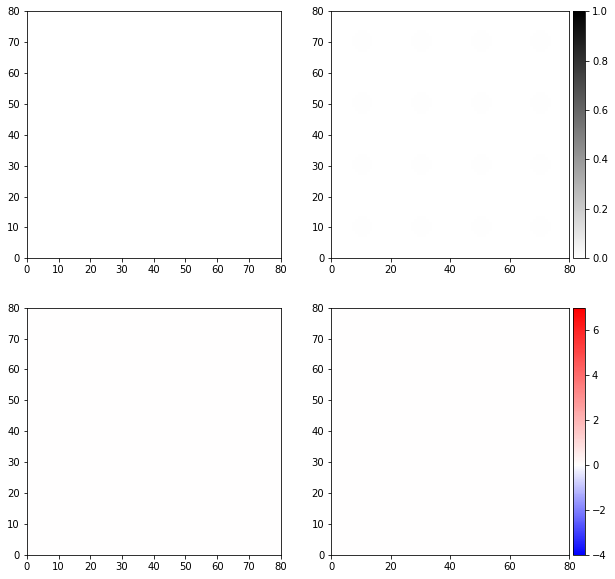

In [15]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
upc = ax1.pcolor(sph_3tiled[:,:,20],cmap="gray_r",vmin=0,vmax=1)
upg = ax2.pcolor(z3d_3tiled[:,:,20],cmap="gray_r",vmin=0,vmax=1)
poc = ax3.pcolor(S[:,:,20],cmap="bwr",vmin=vmin,vmax=vmax,norm=norm47)
pog = ax4.pcolor(G3[:,:,20],cmap="bwr",vmin=vmin,vmax=vmax,norm=norm47)

colorbar(upg); colorbar(pog)
plt.savefig(figdir + "3Dtilegauss_halfZplane.png")

<ipython-input-16-a182e7f80e7b>:4: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  poc = ax3.pcolor(S[:,40,:],cmap="bwr",vmin=vmin,vmax=vmax,norm=norm47)
<ipython-input-16-a182e7f80e7b>:5: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  pog = ax4.pcolor(G3[:,40,:],cmap="bwr",vmin=vmin,vmax=vmax,norm=norm47)


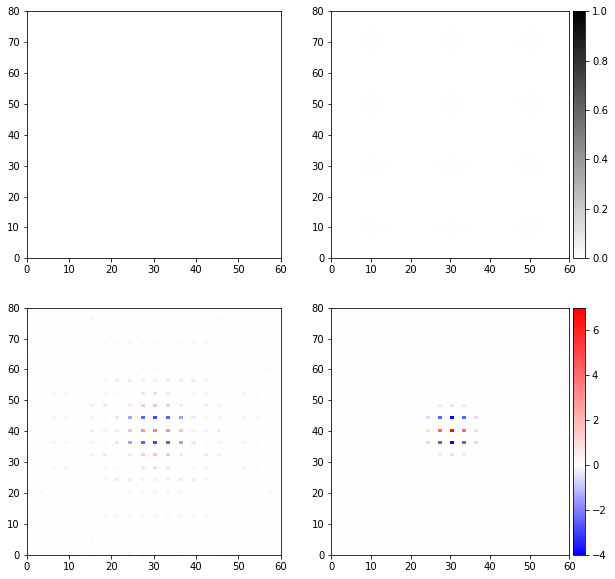

In [16]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
upc = ax1.pcolor(sph_3tiled[:,40,:],cmap="gray_r",vmin=0,vmax=1)
upg = ax2.pcolor(z3d_3tiled[:,40,:],cmap="gray_r",vmin=0,vmax=1)
poc = ax3.pcolor(S[:,40,:],cmap="bwr",vmin=vmin,vmax=vmax,norm=norm47)
pog = ax4.pcolor(G3[:,40,:],cmap="bwr",vmin=vmin,vmax=vmax,norm=norm47)

colorbar(upg); colorbar(pog)

plt.savefig(figdir + "3Dtilegauss_zeroYplane.png")

<ipython-input-17-18432cb81819>:4: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  poc = ax3.pcolor(S[:,30,:],cmap="bwr",vmin=vmin,vmax=vmax,norm=norm47)
<ipython-input-17-18432cb81819>:5: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  pog = ax4.pcolor(G3[:,30,:],cmap="bwr",vmin=vmin,vmax=vmax,norm=norm47)


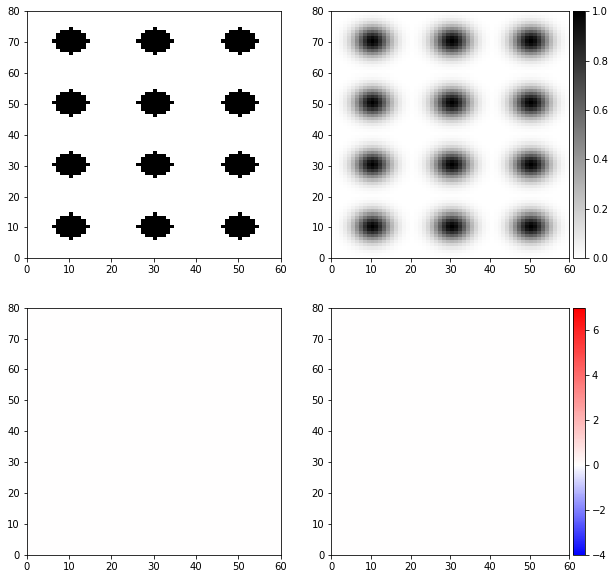

In [17]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
upc = ax1.pcolor(sph_3tiled[:,30,:],cmap="gray_r",vmin=0,vmax=1)
upg = ax2.pcolor(z3d_3tiled[:,30,:],cmap="gray_r",vmin=0,vmax=1)
poc = ax3.pcolor(S[:,30,:],cmap="bwr",vmin=vmin,vmax=vmax,norm=norm47)
pog = ax4.pcolor(G3[:,30,:],cmap="bwr",vmin=vmin,vmax=vmax,norm=norm47)

colorbar(upg); colorbar(pog)

plt.savefig(figdir + "3Dtilegauss_halfYplane.png")

<ipython-input-18-a79c3c0fb5b8>:4: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  poc = ax3.pcolor(S[40,:,:],cmap="bwr",vmin=vmin,vmax=vmax,norm=norm47)
<ipython-input-18-a79c3c0fb5b8>:5: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  pog = ax4.pcolor(G3[40,:,:],cmap="bwr",vmin=vmin,vmax=vmax,norm=norm47)


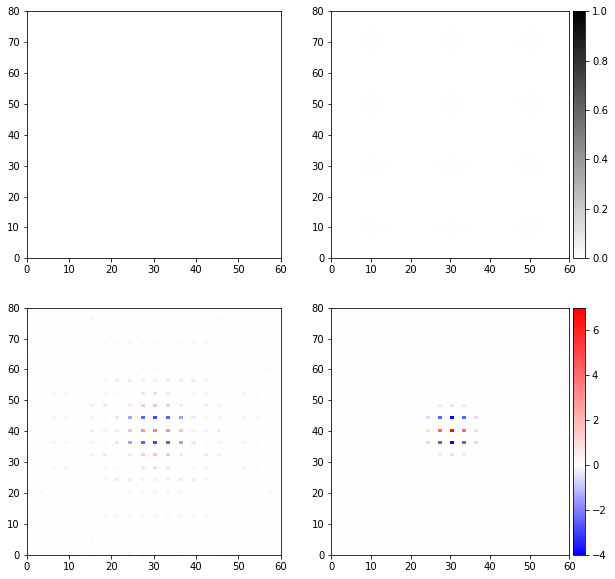

In [18]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
upc = ax1.pcolor(sph_3tiled[40,:,:],cmap="gray_r",vmin=0,vmax=1)
upg = ax2.pcolor(z3d_3tiled[40,:,:],cmap="gray_r",vmin=0,vmax=1)
poc = ax3.pcolor(S[40,:,:],cmap="bwr",vmin=vmin,vmax=vmax,norm=norm47)
pog = ax4.pcolor(G3[40,:,:],cmap="bwr",vmin=vmin,vmax=vmax,norm=norm47)

colorbar(upg); colorbar(pog)
plt.savefig(figdir + "3Dtilegauss_zeroXplane.png")

<ipython-input-19-5cedc7cab90b>:4: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  poc = ax3.pcolor(S[30,:,:],cmap="bwr",vmin=vmin,vmax=vmax,norm=norm47)
<ipython-input-19-5cedc7cab90b>:5: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  pog = ax4.pcolor(G3[30,:,:],cmap="bwr",vmin=vmin,vmax=vmax,norm=norm47)


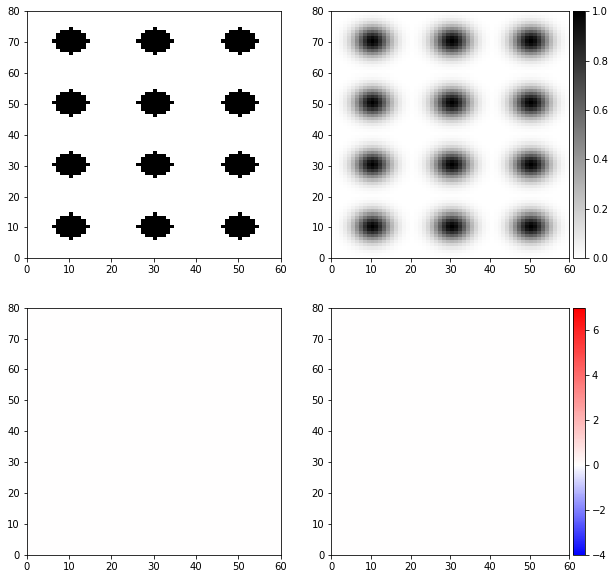

In [19]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
upc = ax1.pcolor(sph_3tiled[30,:,:],cmap="gray_r",vmin=0,vmax=1)
upg = ax2.pcolor(z3d_3tiled[30,:,:],cmap="gray_r",vmin=0,vmax=1)
poc = ax3.pcolor(S[30,:,:],cmap="bwr",vmin=vmin,vmax=vmax,norm=norm47)
pog = ax4.pcolor(G3[30,:,:],cmap="bwr",vmin=vmin,vmax=vmax,norm=norm47)

colorbar(upg); colorbar(pog)
plt.savefig(figdir + "3Dtilegauss_halfXplane.png")